In [7]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

[[0.21052632 0.31578947 0.15789474 0.31578947]
 [0.26666667 0.33333333 0.2        0.2       ]
 [0.23076923 0.26923077 0.38461538 0.11538462]
 [0.08333333 0.29166667 0.29166667 0.33333333]]


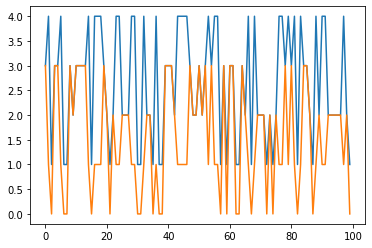

In [43]:
from hmmlearn import hmm
np.random.seed(42)
X = np.random.choice([1, 2, 3, 4], 100).reshape(-1, 1)
model = hmm.GMMHMM(n_components=4, n_iter=len(X)*100, covariance_type="diag")
model.startprob_ = np.array([0.25, 0.25, 0.25, 0.25])
model.fit(X)
Z = model.predict(X)
print(model.transmat_)
plt.plot(X)
plt.plot(Z)
#print(Z)
#dir(model)

In [4]:
SPEC = "carinata"

In [5]:
def lower_collect(seq):
    temp = []
    for s in seq:
        if s.islower(): temp.append(s)
    return temp

In [6]:
raw_data = {}
with open(f"./{SPEC}_validate/{SPEC}.LTR.LTR.fasta", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        if len(record.id) < 4: 
            raw_data[record.id] = []
        
with open(f"./{SPEC}_validate/{SPEC}.LTR.LTR.fasta", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        if len(record.id) < 4:
            # raw_data[record.id] += lower_collect(record.seq)
            raw_data[record.id] += str(record.seq).lower()

data = {}
for k in raw_data.keys():
    data[k] = "".join(raw_data[k])
    

del raw_data

In [7]:
data.keys()

dict_keys(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])

In [8]:
try: 
    del data[""]
    del data["com"]
except: pass

In [9]:
data.keys()

dict_keys(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])

In [39]:
def signal_generator(seq):
    #signal = {"A":[], "T":[], "G":[], "C":[]}
    signal = []
    # A: 135.13 T: 126.115 G: 151.13 C: 111.10
    properties = [135.13, 126.115, 151.13, 111.10]
    
    weight = {"a": (properties[0] - np.mean(properties))/np.std(properties), "t": (properties[1] - np.mean(properties))/np.std(properties), \
              "g": (properties[2] - np.mean(properties))/np.std(properties), "c": (properties[3] - np.mean(properties))/np.std(properties), "N": 0}
    # weight = {"a": 1, "t": -1, "g": 1j, "c": -1j}
    
    #for k in signal.keys():
    #    for s in seq:
    #        if s == k: signal[k].append(10)
    #        else: signal[k].append(-10)
    for s in seq:
        signal.append(weight[s])
    return signal

In [40]:
signal_data = {}
for k in tqdm(data.keys()):
    signal_data[k] = signal_generator(data[k])

100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


In [41]:
def distDTW(ts1, ts2):
    DTW = {}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)):
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return sqrt(DTW[len(ts1)-1, len(ts2)-1])

In [42]:
def padding(v, M):
    r = []
    for i in range(M):
        try:
            r.append(v[i])
        except IndexError: 
            r.append(0)
    return r

In [43]:
M = max([len(x) for x in data.values()])
feature = []
for v in tqdm(signal_data.values()):
    feature.append(padding(v, M))

In [44]:
feature_values = preprocessing.scale(feature)

In [45]:
feature = pd.DataFrame(feature_values, index=data.keys())
feature

,0,1,2,3,4,5,6,7,8,9,...,3481692,3481693,3481694,3481695,3481696,3481697,3481698,3481699,3481700,3481701
B1,0.196592,0.373628,0.408333,0.277614,0.608415,-0.170423,-1.429949,0.495941,-1.595642,0.369849,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B2,0.196592,-0.306585,-0.175291,0.277614,-1.176780,-1.411722,-1.429949,-0.365994,1.289266,0.369849,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B3,-0.485825,-1.439519,1.444161,1.672095,-0.061311,-0.170423,0.331429,-0.365994,1.289266,-1.562706,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B4,-1.622431,1.580883,-0.175291,-0.508088,-1.176780,-1.411722,0.331429,-1.801597,-1.595642,1.656611,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B5,0.196592,0.373628,-0.175291,0.277614,0.608415,0.574852,0.331429,0.495941,1.289266,-0.355160,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B6,0.196592,0.373628,-1.147350,0.277614,0.608415,-1.411722,-1.429949,2.025721,0.136167,0.369849,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B7,-1.622431,0.373628,-1.147350,-1.816721,-1.176780,0.574852,0.331429,-0.365994,-1.595642,0.369849,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
B8,-0.485825,1.580883,0.408333,-0.508088,-0.061311,-0.170423,0.331429,0.495941,0.136167,1.656611,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25
C1,1.407760,-0.306585,1.444161,1.672095,1.797060,1.897581,1.388960,2.025721,0.136167,0.369849,...,4.00,4.00,4.00,-4.00,4.00,-4.00,-4.00,-4.00,-4.00,-4.00
C2,0.196592,-1.439519,-1.147350,0.277614,-1.176780,0.574852,0.331429,-0.365994,-1.595642,-0.355160,...,-0.25,-0.25,-0.25,0.25,-0.25,0.25,0.25,0.25,0.25,0.25


In [ ]:
p = pdist(feature, metric=distDTW)
with open("pairwise_distance.npy", "wb") as f:
    np.save(f, p)
    

In [ ]:
feature_clustering = AgglomerativeClustering(n_clusters = 2, linkage="average", affinity="precomputed")
feature_clustering.fit(feature_values)
feature["predict"] = feature_clustering.fit_predict(p)


In [ ]:
feature["predict"]



# legacy

In [85]:
plt.figure(figsize=(30, 20))
linked = linkage(df.T, method="ward", metric=metric)
print("Linkage map calculation ended")
dend = dendrogram(linked, orientation='top', distance_sort='descending', \
                  labels=list(df.T.index), show_leaf_counts=True)
plt.savefig(f"./{SPEC}_dendrogram.png")

TypeError: metric() takes 1 positional argument but 2 were given

<Figure size 2160x1440 with 0 Axes>

<AxesSubplot:ylabel='Frequency'>

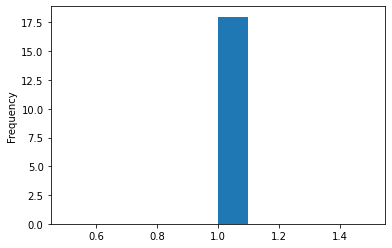

In [45]:
from sklearn.mixture import GaussianMixture
gmm_np = GaussianMixture(n_components=2, random_state=39).fit_predict(df[:100000])
gmm_l = list(gmm_np)
gmm_dict = {}
for n, v in zip(data.keys(), gmm_l):
    gmm_dict[n] = v
gmm_df = pd.Series(gmm_dict)
gmm_df.plot(kind="hist")

In [46]:
gmm_df

1K    1
1N    1
2K    1
2N    1
3K    1
3N    1
4K    1
4N    1
5K    1
5N    1
6K    1
6N    1
7K    1
7N    1
8K    1
8N    1
9K    1
9N    1
dtype: int64

In [68]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=39)
model.fit(df)
kmeans = model.fit_predict(df[:-200])
kmeans

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)